In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [43]:
trainD = pd.read_csv("train.csv", index_col = 'Loan ID')
testD = pd.read_csv("test.csv", index_col = 'Loan ID')
print(trainD.shape)
print(testD.shape)

(100514, 18)
(10353, 17)


In [44]:
trainD['Purpose'] = trainD['Purpose'].str.title()

In [45]:
trainD = trainD.drop('Customer ID', axis=1)
testD = testD.drop('Customer ID', axis=1)

In [46]:
print("Percentages of each value in 'Loan Status':",
      (trainD["Loan Status"].value_counts(dropna=False)/len(trainD['Loan Status'])*100))

Percentages of each value in 'Loan Status': Loan Status
Fully Paid     76.965398
Charged Off    22.523231
NaN             0.511372
Name: count, dtype: float64


In [47]:
trainD = trainD.dropna(subset=["Loan Status"])

trainD["Loan Status"] = trainD["Loan Status"].map({
    "Fully Paid": 1, "Charged Off": 0})
print("Percentages of each value in 'Loan Status':\n",
      (trainD["Loan Status"].value_counts(dropna=False)/len(trainD['Loan Status'])*100))

Percentages of each value in 'Loan Status':
 Loan Status
1    77.361
0    22.639
Name: count, dtype: float64


In [48]:
trainD['Credit Score'] = trainD['Credit Score'].mask(trainD['Credit Score'] > 1000, np.nan)
testD['Credit Score'] = testD['Credit Score'].mask(testD['Credit Score'] > 1000, np.nan)

trainD = trainD.dropna(subset=['Credit Score'])
testD = testD.dropna(subset=['Credit Score'])

In [49]:
col = trainD['Credit Score']
 
mean = col.mean()
std = col.std()
 
z_scores = (col - mean) / std
 
 
bins = [-np.inf, 600, 630, 660, 690, 720, 750, np.inf]
labels = ['<600', '600-629', '630-659', '660-689', '690-719', '720-749', '>=750']
 
trainD['CreditScore_Band'] = pd.cut(trainD['Credit Score'], bins=bins, labels=labels)
testD['CreditScore_Band'] = pd.cut(testD['Credit Score'], bins=bins, labels=labels)

trainD['CreditScore_Band'].value_counts().sort_index()

CreditScore_Band
<600         200
600-629      916
630-659     2769
660-689     7868
690-719    23770
720-749    40049
>=750        723
Name: count, dtype: int64

<Axes: xlabel='Current Loan Amount', ylabel='Count'>

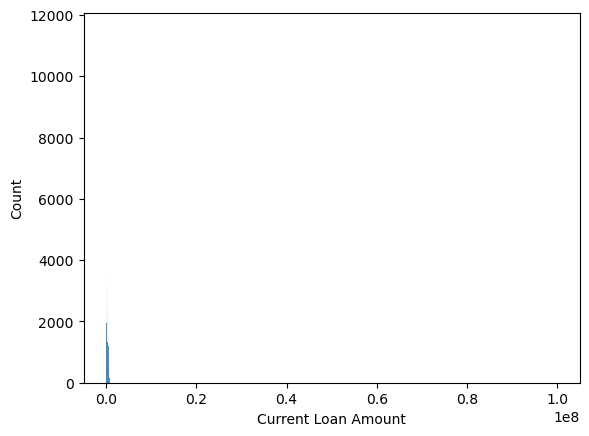

In [50]:
sns.histplot(data = trainD, x="Current Loan Amount")

In [51]:
trainD['Current Loan Amount'].describe()

count    7.629500e+04
mean     1.531821e+07
std      3.564677e+07
min      1.124200e+04
25%      1.867030e+05
50%      3.255780e+05
75%      5.568860e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [52]:
col_to_remove_outliers = ['Current Loan Amount', 'Monthly Debt', 'Maximum Open Credit', 'Annual Income']
for col in col_to_remove_outliers:
    trainD=trainD[np.abs(trainD[col] -trainD[col].mean()) <= (2 *trainD[col].std())]
    testD=testD[np.abs(testD[col] -testD[col].mean()) <= (2 *testD[col].std())]

print(trainD.shape)
print(testD.shape)

(60161, 18)
(5886, 17)


<Axes: xlabel='Current Loan Amount', ylabel='Count'>

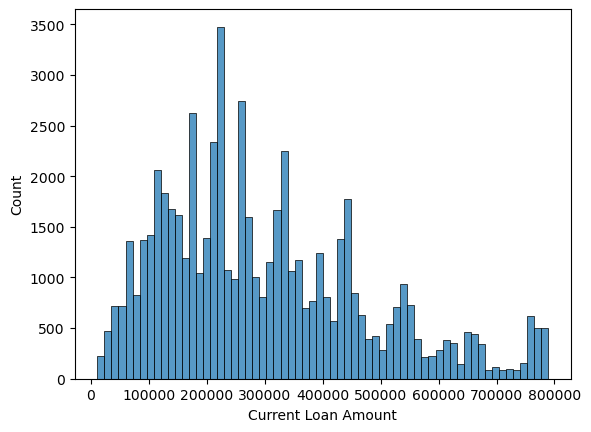

In [53]:
sns.histplot(data = trainD, x="Current Loan Amount")

In [54]:
trainD['Current Loan Amount'].describe()

count     60161.000000
mean     298743.940194
std      176826.341655
min       11242.000000
25%      163614.000000
50%      262680.000000
75%      405284.000000
max      789250.000000
Name: Current Loan Amount, dtype: float64

In [55]:
trainD.isna().sum()

Loan Status                         0
Current Loan Amount                 0
Term                                0
Credit Score                        0
Annual Income                       0
Years in current job             2699
Home Ownership                      0
Purpose                             0
Monthly Debt                        0
Years of Credit History             0
Months since last delinquent    31625
Number of Open Accounts             0
Number of Credit Problems           0
Current Credit Balance              0
Maximum Open Credit                 0
Bankruptcies                      115
Tax Liens                           5
CreditScore_Band                    0
dtype: int64

In [56]:
col_to_remove = ['Years in current job', 'Months since last delinquent', 'CreditScore_Band']
for col in col_to_remove:
    trainD = trainD.drop(col, axis = 1)
    tetsttD = testD.drop(col, axis = 1)

col_mask_nan = ['Bankruptcies', 'Tax Liens']
for col in col_mask_nan:
    trainD[col] = trainD[col].fillna(-1)
    testD[col] = testD[col].fillna(-1)
trainD.isna().sum()

Loan Status                  0
Current Loan Amount          0
Term                         0
Credit Score                 0
Annual Income                0
Home Ownership               0
Purpose                      0
Monthly Debt                 0
Years of Credit History      0
Number of Open Accounts      0
Number of Credit Problems    0
Current Credit Balance       0
Maximum Open Credit          0
Bankruptcies                 0
Tax Liens                    0
dtype: int64

In [57]:
y_train = trainD['Loan Status']
X_train = trainD.drop(columns=['Loan Status'])
X_test = testD.copy()

nominal_categories = ['Term', 'Home Ownership', 'Purpose']

ohe = OneHotEncoder( 
    handle_unknown='ignore',
    sparse_output=False)

X_train_cat = ohe.fit_transform(X_train[nominal_categories])
X_test_cat = ohe.transform(X_test[nominal_categories])

cat_feature_names = ohe.get_feature_names_out(nominal_categories)

X_train_cat = pd.DataFrame(
    X_train_cat,
    columns=cat_feature_names,
    index=X_train.index
)

X_test_cat = pd.DataFrame(
    X_test_cat,
    columns=cat_feature_names,
    index=X_test.index
)

num_cols = X_train.columns.difference(nominal_categories)

scaler = StandardScaler()

X_train_num_scaled = scaler.fit_transform(X_train[num_cols])
X_test_num_scaled = scaler.transform(X_test[num_cols])

X_train_num_scaled_df = pd.DataFrame(
    X_train_num_scaled,
    columns=num_cols,
    index=X_train.index
)

X_test_num_scaled_df = pd.DataFrame(
    X_test_num_scaled,
    columns=num_cols,
    index=X_test.index
)

X_train_final = pd.concat([X_train_num_scaled_df, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_num_scaled_df, X_test_cat], axis=1)

In [58]:
print(X_train_final.shape)

(60161, 32)


In [59]:
y_train.value_counts()

Loan Status
1    48240
0    11921
Name: count, dtype: int64

In [60]:
purpose_cols = [col for col in X_train_final.columns if 'Purpose' in col]

counts = X_train_final[purpose_cols].apply(lambda x: (x == 1).sum())
print(counts)

Purpose_Business Loan             914
Purpose_Buy A Car                 751
Purpose_Buy House                 412
Purpose_Debt Consolidation      47232
Purpose_Educational Expenses       60
Purpose_Home Improvements        3325
Purpose_Major_Purchase            203
Purpose_Medical Bills             671
Purpose_Moving                     82
Purpose_Other                    5860
Purpose_Renewable_Energy            6
Purpose_Small_Business            169
Purpose_Take A Trip               359
Purpose_Vacation                   56
Purpose_Wedding                    61
dtype: int64


In [61]:
counting = trainD['Purpose'].value_counts(dropna = False).sum()
print("Items in orignal 'Purpose' column:\t", counting,
      "\nItems in all new one hot coded columns:\t", counts.sum(),
     "\nAre they equal?\t\t\t\t", (counts.sum() == counting))

Items in orignal 'Purpose' column:	 60161 
Items in all new one hot coded columns:	 60161 
Are they equal?				 True


In [62]:
def undersample_training(X_train, y_train, target_ratio=2.0):
    
    majority_class = 1 
    minority_class = 0  
    
    majority_idx = np.where(y_train == majority_class)[0]
    minority_idx = np.where(y_train == minority_class)[0]
    
    n_minority = len(minority_idx)
    target_n_majority = int(target_ratio * n_minority)
    
    
    np.random.seed(42)
    selected_majority_idx = np.random.choice(
        majority_idx, 
        size=target_n_majority, 
        replace=False
    )
    
    undersampled_idx = np.concatenate([selected_majority_idx, minority_idx])
    
    return X_train.iloc[undersampled_idx], y_train.iloc[undersampled_idx]

In [63]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_final, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_train_under, y_train_under = undersample_training(X_train_split,
                                                    y_train_split, 
                                                    target_ratio=2.0)

print(y_train_under.value_counts())

Loan Status
1    19074
0     9537
Name: count, dtype: int64


Training Accuracy: 0.5791
Validation Accuracy: 0.5761

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.61      0.36      2384
           1       0.85      0.57      0.68      9649

    accuracy                           0.58     12033
   macro avg       0.56      0.59      0.52     12033
weighted avg       0.74      0.58      0.62     12033

Confusion Matrix:


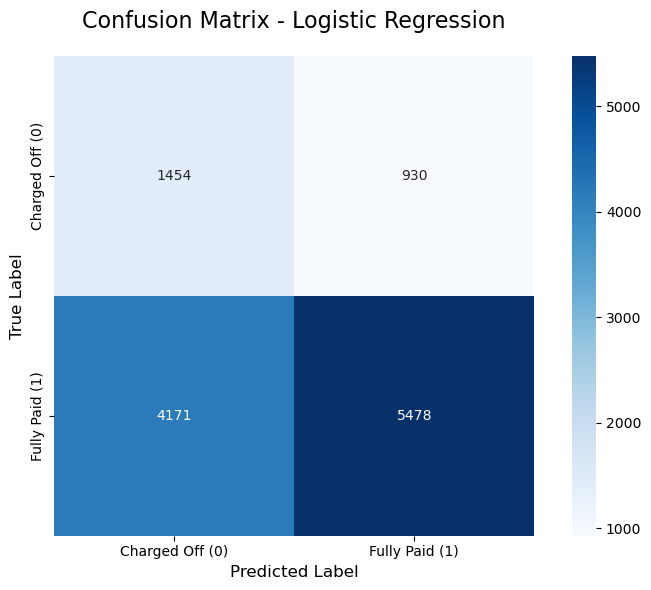

In [65]:
lg_classifier = LogisticRegression(class_weight='balanced', max_iter=1000)

lg_classifier.fit(X_train_under, y_train_under)

y_val_pred_log_reg = lg_classifier.predict(X_val)

log_reg_train_acc = round(lg_classifier.score(X_train_under, y_train_under), 4)
log_reg_val_acc = round(accuracy_score(y_val, y_val_pred_log_reg), 4)
log_reg_precision = round(precision_score(y_val, y_val_pred_log_reg), 4)
log_reg_recall = round(recall_score(y_val, y_val_pred_log_reg), 4)
log_reg_f1 = round(f1_score(y_val, y_val_pred_log_reg), 4)

print("Training Accuracy:", log_reg_train_acc)
print("Validation Accuracy:", log_reg_val_acc)

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_log_reg))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_val_pred_log_reg)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)  

plt.title('Confusion Matrix - Logistic Regression', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

class_names = ['Charged Off (0)', 'Fully Paid (1)']
plt.xticks(ticks=[0.5, 1.5], labels=class_names)
plt.yticks(ticks=[0.5, 1.5], labels=class_names)

plt.tight_layout()
plt.show()

Training Accuracy: 1.0
Validation Accuracy: 0.6558

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.39      0.31      2384
           1       0.83      0.72      0.77      9649

    accuracy                           0.66     12033
   macro avg       0.54      0.56      0.54     12033
weighted avg       0.72      0.66      0.68     12033

Confusion Matrix:


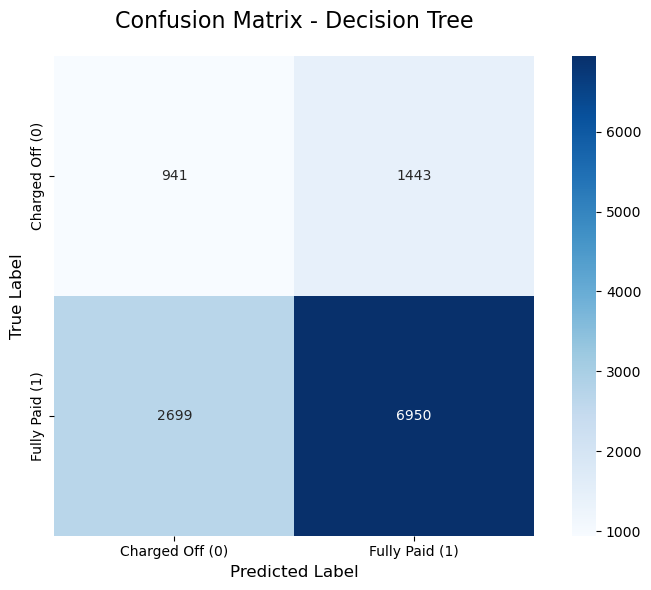

In [66]:
dt_classifier = DecisionTreeClassifier(class_weight='balanced')

dt_classifier.fit(X_train_under, y_train_under)

y_val_pred_dt = dt_classifier.predict(X_val)

dt_train_acc = round(dt_classifier.score(X_train_under, y_train_under), 4)
dt_val_acc = round(accuracy_score(y_val, y_val_pred_dt), 4)
dt_precision = round(precision_score(y_val, y_val_pred_dt), 4)
dt_recall = round(recall_score(y_val, y_val_pred_dt), 4)
dt_f1 = round(f1_score(y_val, y_val_pred_dt), 4)

print("Training Accuracy:", dt_train_acc)
print("Validation Accuracy:", dt_val_acc)

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_dt))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_val_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)  

plt.title('Confusion Matrix - Decision Tree', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.xticks(ticks=[0.5, 1.5], labels=class_names)
plt.yticks(ticks=[0.5, 1.5], labels=class_names)

plt.tight_layout()
plt.show()

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight = 'balanced')

rf_classifier.fit(X_train_under, y_train_under)

y_val_pred_rf = rf_classifier.predict(X_val)

rf_train_acc = round(rf_classifier.score(X_train_under, y_train_under), 4)
rf_val_acc = round(accuracy_score(y_val, y_val_pred_rf), 4)
rf_precision = round(precision_score(y_val, y_val_pred_rf), 4)
rf_recall = round(recall_score(y_val, y_val_pred_rf), 4)
rf_f1 = round(f1_score(y_val, y_val_pred_rf), 4)

print("Training Accuracy:", rf_train_acc)
print("Validation Accuracy:", rf_val_acc)

print("Classification Report:")
print(classification_report(y_val, y_val_pred_rf))

cm = confusion_matrix(y_val, y_val_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)   

plt.title('Confusion Matrix - Random Forest', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.xticks(ticks=[0.5, 1.5], labels=class_names)
plt.yticks(ticks=[0.5, 1.5], labels=class_names)

plt.tight_layout()
plt.show()

In [ ]:
gb_classifier = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state = 42)

gb_classifier.fit(X_train_under, y_train_under)

y_val_pred_gb = gb_classifier.predict(X_val)

gb_train_acc = round(gb_classifier.score(X_train_under, y_train_under), 4)
gb_val_acc = round(accuracy_score(y_val, y_val_pred_gb), 4)
gb_precision = round(precision_score(y_val, y_val_pred_gb), 4)
gb_recall = round(recall_score(y_val, y_val_pred_gb), 4)
gb_f1 = round(f1_score(y_val, y_val_pred_gb), 4)

print("Training Accuracy:", gb_train_acc)
print("Validation Accuracy:", gb_val_acc)

print("Classification Report:")
print(classification_report(y_val, y_val_pred_gb))

cm = confusion_matrix(y_val, y_val_pred_gb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)  

plt.title('Confusion Matrix - Gradient Boosting', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.xticks(ticks=[0.5, 1.5], labels=class_names)
plt.yticks(ticks=[0.5, 1.5], labels=class_names)

plt.tight_layout()
plt.show()

In [ ]:
training_accuracies = {'Logistic Regression': log_reg_train_acc,
                       'Decision Tree': dt_train_acc,
                       'Random Forest': rf_train_acc,
                       'Gradient Boosting': gb_train_acc
                      }

val_accuracies = {'Logistic Regression': log_reg_val_acc,
                  'Decision Tree': dt_val_acc,
                  'Random Forest': rf_val_acc,
                  'Gradient Boosting': gb_val_acc
                 }

precision_scores = {'Logistic Regression': log_reg_precision,
                    'Decision Tree': dt_precision,
                    'Random Forest': rf_precision,
                    'Gradient Boosting': gb_precision
                   }

recall_scores = {'Logistic Regression': log_reg_recall,
                 'Decision Tree': dt_recall,
                 'Random Forest': rf_recall,
                 'Gradient Boosting': gb_recall
                }

f1_scores = {'Logistic Regression': log_reg_f1,
             'Decision Tree': dt_f1,
             'Random Forest': rf_f1,
             'Gradient Boosting': gb_f1
            }

In [ ]:
models = list(training_accuracies.keys())
train_acc = list(training_accuracies.values())
val_acc = list(val_accuracies.values())

train_avg = np.mean(train_acc)
val_avg = np.mean(val_acc)


fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(models))
width = 0.35

bars_train = ax.bar(x - width/2, train_acc, width, label='Training', color='blue', alpha=0.6)
bars_val = ax.bar(x + width/2, val_acc, width, label='Validation', color='red', alpha=0.6)

ax.axhline(y=train_avg, color='blue', linestyle='--', linewidth=2.5, 
           alpha=0.4, label=f'Training Avg: {train_avg:.4f}')
ax.axhline(y=val_avg, color='red', linestyle='--', linewidth=2.5, 
           alpha=0.4, label=f'Validation Avg: {val_avg:.4f}')

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, ha='center', fontsize=11)
ax.legend(loc='lower right', fontsize=10)

def autolabel(bars, offset=0.00005):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + offset, f'{height:.4f}', ha='center', va='bottom', fontsize=9)

autolabel(bars_train)
autolabel(bars_val)

plt.grid(axis='y', alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

In [ ]:
prec = list(precision_scores.values())
recall = list(recall_scores.values())
f1 = list(f1_scores.values())

prec_avg = np.mean(prec)
recall_avg = np.mean(recall)
f1_avg = np.mean(f1)


fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(models))
width = 0.25

bars_prec = ax.bar(x - width, prec, width, label='Precision', color='blue', alpha=0.6)
bars_recall = ax.bar(x, recall, width, label='Recall', color='purple', alpha=0.6)
bars_f1 = ax.bar(x + width, f1, width, label='F1', color='red', alpha=0.6)

ax.axhline(y=prec_avg, color='blue', linestyle='--', linewidth=2.5, 
           alpha=0.6, label=f'Precision Avg: {prec_avg:.4f}')
ax.axhline(y=recall_avg, color='purple', linestyle='--', linewidth=2.5, 
           alpha=0.4, label=f'Recall Avg: {recall_avg:.4f}')
ax.axhline(y=f1_avg, color='red', linestyle='--', linewidth=2.5, 
           alpha=0.6, label=f'F1 Avg: {f1_avg:.4f}')

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, ha='center', fontsize=11)
ax.legend(loc='lower right', fontsize=10)

def autolabel(bars, offset=0.00005):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + offset, f'{height:.4f}', ha='center', va='bottom', fontsize=9)

autolabel(bars_prec)
autolabel(bars_recall)
autolabel(bars_f1)

plt.grid(axis='y', alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

In [ ]:
predictions = {}
prediction_probs = {}

models = [
    ('Random Forest', rf_classifier),
    ('Gradient Boosting', gb_classifier)
]

for model_name, model in models:
    preds = model.predict(X_test_final)
    predictions[model_name] = preds
    
    probs = model.predict_proba(X_test_final)[:, 1]
    prediction_probs[model_name] = probs
    
    n_default = sum(preds == 0)
    n_paid = sum(preds == 1)
    
    print(f"\n{model_name}:")
    print(f"Charged Off:\t{n_default:,} loans ({100*n_default/len(preds):.1f}%)")
    print(f"Fully Paid:\t{n_paid:,} loans ({100*n_paid/len(preds):.1f}%)")

In [ ]:
categories = ['Charged Off', 'Fully Paid']
rf_counts = [sum(predictions['Random Forest'] == 0), sum(predictions['Random Forest'] == 1)]
gb_counts = [sum(predictions['Gradient Boosting'] == 0), sum(predictions['Gradient Boosting'] == 1)]

plt.figure(figsize=(6,4))

x = np.arange(len(categories))
width = 0.4

bars_rf = plt.bar(x - width/2, rf_counts, width, 
                  label='Random Forest', color='blue', alpha=0.6)
bars_gb = plt.bar(x + width/2, gb_counts, width, 
                  label='Gradient Boosting', color='red', alpha=0.6)

plt.xlabel('Predicted Loan Status', fontsize=12)
plt.ylabel('Number of Loans', fontsize=12)
plt.xticks(x, categories, fontsize=9, ha = 'center')
plt.legend(fontsize=8)

for bars, counts in [(bars_rf, rf_counts), (bars_gb, gb_counts)]:
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height,
                f'{count}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
comparison_df = pd.DataFrame(predictions)
comparison_df['Agree'] = comparison_df['Random Forest'] == comparison_df['Gradient Boosting']
comparison_df['Disagreement'] = ~comparison_df['Agree']

total_loans = len(comparison_df)
agree_count = comparison_df['Agree'].sum()
disagree_count = comparison_df['Disagreement'].sum()

print(f"\n Model Agreement:")
print(f"   Both models agree: {agree_count:,} loans ({100*agree_count/total_loans:.1f}%)")
print(f"   Models disagree:   {disagree_count:,} loans ({100*disagree_count/total_loans:.1f}%)")

In [ ]:
plt.figure(figsize = (6,4))

agreement_labels = ['Models Disagree', 'Models Agree']
agreement_counts = [disagree_count, agree_count]

colors = ['red', 'green']

bars = plt.bar(agreement_labels, agreement_counts, 
               color=colors, alpha=0.6)

plt.xlabel('Agreement Status', fontsize=12)
plt.ylabel('Number of Loans', fontsize=12)

for bar, count in zip(bars, agreement_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height, count, ha='center', va='bottom', fontsize=9)

plt.ylim(0, 6000)
plt.xticks(agreement_labels, fontsize=9, ha = 'center')
plt.tight_layout()
plt.show()